# Image Reconstruction
## NSE LAB
### Use of this notebook is intended for dual camera calibration using openCV 3.4.1 for NSE rat reaching experiments. 

In [1]:
import sys 
import glob
import os
import pickle
import pandas as pd
import numpy as np
#Necessary to import CV2 for Computers with ROS installed 
ROS_path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if ROS_path in sys.path:
    sys.path.remove(ROS_path)
import cv2
%matplotlib inline

# Camera Calibration

### Camera calibration is required in order to translate between pixel coordinates and euclidean (real-world) coordinates. The code below uses multiple images from each camera of a checkerboard in order to obtain both information about the camera and the translational error that occurs when one transforms from one coordinate set to another. This approach can be found on the openCV website https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html . Other calibration approaches exist that may be used that utilize different geometric quantities. They have similar algorithms that perform calibration on these patterns.


# Calibration Requirements

### We require 15-20 second video of a chessboard with known square-size dimensions captured by both cameras. This video must be done with excellent lighting as well as checkerboard firmly inside each cameras field of view. A variety of angles and positions should be used, in order to make calibration more accurate.
### We then take this video and break it down into frames, selecting between 40-60 different frames (can use more if needed for better accuracy, as a larger sample size will yield more accurate results from the algorithm...) We then use these frames in the code below.
### This post from stackexchange is an excellent guide to achieving consistent, accurate calibration. https://stackoverflow.com/questions/12794876/how-to-verify-the-correctness-of-calibration-of-a-webcam


In [2]:
owd = os.getcwd()

#Directory that contains images that will be used for calibration
images_dir = 'Cal_a' #CHANGE ME TO CORRECT DIRECTORY EACH TIME YOU USE

#internal corners of image for x and y axis
int_crn_x = 9
int_crn_y = 9

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((int_crn_x*int_crn_y,3), np.float32)
objp[:,:2] = np.mgrid[0:int_crn_y,0:int_crn_x].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

os.chdir(owd)
os.chdir(images_dir + '/')
it = 0
for fname in os.listdir('.'):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (int_crn_y ,int_crn_x),None)
    #print('ChessboardCorners completed')
    # If found, add object points, image points (after refining them)
    if ret == True:
       # print('Corners found for: '+ fname)
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
         # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (int_crn_y,int_crn_x), corners2,ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
# rendering the chessboard images here, doublecheck this please for error before moving on to the actual calibration...
cv2.destroyAllWindows()
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

        

## Serialize Calibration Parameters

In [5]:
#Store parameters in a calibration dictionary
calib_dict = {'ret': ret, 'mtx': mtx, 'dist': dist, 'rvecs': rvecs, 'tvecs': tvecs}
#Move back up to not have serialized file stored in pictures directory
os.chdir(owd)
#store dictionary into pickle file
with open(images_dir + '_dict.pickle', 'wb') as handle:
    pickle.dump(calib_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Loading in Calibration Data
### Previously computed calibration data for a camera system can be used. This will lead to accurate results only if the camera positioning has not been disturbed.

In [10]:
calib_data = 'Cal_a_dict.pickle'

In [11]:
infile = open(calib_data,'rb')
dftype = pickle.load(infile)
infile.close()
#print (dftype)

## We also need to load in DLC pixel coordinates that have been generated at a seperate date. These coordinates MUST be from the experiment that calibration was run for (check the dates please..)

In [12]:
filename = 'handle_videoDeepCut_resnet50_Demo2Jan30shuffle1_150000.h5'
pd.read_hdf(filename)

FileNotFoundError: File handle_videoDeepCut_resnet50_Demo2Jan30shuffle1_150000.h5 does not exist

## Now we load in the calibration images themselves. These images should be picked from the calibration image data that was used. Images should be chosen in order to maximize the number of different ways the checkerboard was shown to the camera while having the SAME TIME STAMP. YOU MUST MATCH TIME STAMPS ON THE IMAGES BETWEEN CAMERA A AND B.
# The code below is used to load in pre-calculated calibration data, and then normalize it in order to use in the calculations below.

In [5]:
images_dir = 'Cal_a'

with open(images_dir + '_dict.pickle','rb') as handle:
    load_dict_a = pickle.load(handle)

In [7]:
images_dir = 'Cal_b'

with open(images_to_use + '_dict.pickle','rb') as handle:
    load_dict_b = pickle.load(handle)

In [8]:
ret_b = np.array(load_dict_b['ret'])
mtx_b=np.array(load_dict_b['mtx'])

dist_b = np.array(load_dict_b['dist'])

rvecs_b = np.array(load_dict_b['rvecs'])
tvecs_b = np.array(load_dict_b['tvecs'])
print (tvecs_a)
ret_a = np.array(load_dict_a['ret'])
mtx_a=np.array(load_dict_a['mtx'])
dist_a = np.array(load_dict_a['dist'])
rvecs_a = np.array(load_dict_a['rvecs'])
tvecs_a = np.array(load_dict_a['tvecs'])

# turn list of arrays into ND array

rvecs_b = np.mean(rvecs_b,axis = 0)
print (rvecs_b.shape)
tvecs_b = np.mean(tvecs_b,axis=0)
print (tvecs_b.shape)


# should return means element-wise 
# https://stackoverflow.com/questions/37443565/python-numpy-ndarray-element-wise-mean


[[[ -0.19274855]
  [-10.13519503]
  [ 29.77432543]]

 [[ -0.12982633]
  [-10.2681114 ]
  [ 29.79002582]]

 [[ -0.36085592]
  [-11.40208213]
  [ 27.08130641]]

 [[ -5.59808403]
  [-12.16008749]
  [ 32.32240098]]

 [[ -1.11202041]
  [-12.85732269]
  [ 31.41295148]]

 [[ -3.41386842]
  [-14.50900747]
  [ 39.12970441]]

 [[ -1.73568863]
  [-10.80875257]
  [ 26.32069531]]

 [[ -0.71680689]
  [-11.39198644]
  [ 27.11342852]]

 [[ -1.29417181]
  [-12.8701142 ]
  [ 31.47329042]]

 [[ -5.53235962]
  [-12.68801114]
  [ 35.87231111]]]
(3, 1)
(3, 1)


In [8]:
print (rvecs_b.shape,tvecs_b)

(3, 1) [[ -2.00864306]
 [-11.90906705]
 [ 31.02904399]]


# Translation and Rotation Matrices
## We need to obtain usable translation and rotation matrices for our system. This can be done using RANSAC and openCV https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_pose/py_pose.html. There are other methods as well that leverage vector equations and SVD algorithms to estimate pose parameters, but these can be unwieldy. 

# First, we need to ensure that our vectors are usable for triangulation (explained below)

In [9]:
# turn rotation vector into rotation matrix using Rodriguez formula.
# am using mean of rotation vectors found above.

rotation_mat = np.zeros(shape=(3, 3))
R_b = cv2.Rodrigues(rvecs_b, rotation_mat)[0]

print (R_b)
#P = np.column_stack((np.matmul(mtx_b,R), tvecs_b))
#print (P)

[[ 0.31128665 -0.55496852  0.7714341 ]
 [ 0.92513749  0.36259258 -0.11246   ]
 [-0.21730452  0.7486899   0.62629241]]


## Now, with our modified rotation matrix in hand, we can translate between euclidean (real world) coordinates, as well as perform simple geometric transforms that are not as useful (rotation etc).
## Our transforms are calculated by the terms P'1 = K1 * P1 and P'2 = P2 * K2. Note, choosing cameras is important. Camera "1" is the primary world coordinate camera. We can then use triangulation to map each pixel coordinate to the appropriate coordinates in 3 dimensions. Since P1 is our origin camera, it is the identity matrix. P2 is given by R|T, found above. Triangulation method refined from http://www.morethantechnical.com/2012/01/04/simple-triangulation-with-opencv-from-harley-zisserman-w-code/. 


In [10]:
# calling camera 1 'a' primary
# calling camera 2 'b' secondary
R_T = np.column_stack((R_b,tvecs_b))
K_1 = mtx_a
K_2 = mtx_b
p1 = K_1 * np.identity(3)
zero_string = [0,0,0]
zero_string = np.array(zero_string)

p1 = np.column_stack((p1,zero_string))
p2 = np.matmul(K_2,  R_T)


In [11]:
print (p1.shape,p2.shape)

(3, 4) (3, 4)


In [12]:
# Now I have values for a and B

# Now compose big matrix!!

# I choose camera A to be camera 1
# Camera B will be our R_T vector



#### Now Perform Triangulation for points.. see ####
def true_coords(projMatr1,projMatr2,projPoints1,projPoints2):
    # define true_points array? 
    true_points = cv2.triangulatePoints(projMatr1, projMatr2, projPoints1, projPoints2)
    true_points = true_points / true_points[3]
    return true_points  #return normalized coordinates...




## Now we need to load in and clean the actual DLC coordinates that we need to transform. By clean, we need to both redefine the pixel coordinates in 'x' for features found in the 2nd set of features from the 2nd image (note, match camera 1,2 to feature 1,2 etc)
## We must also sort by probability level. To ensure that we do not use 'risky' or unrealistic DLC generated coordinate pairs, we should make the cutoff above p>0.8.

In [13]:
##### Load in DLC values #####
filename = 'handle_videoDeepCut_resnet50_Demo2Jan30shuffle1_150000.h5'
dataframe = pd.read_hdf(filename)

#### sort values by both probability, normalize pixels (due to two images



In [14]:
dataframe.keys()

MultiIndex(levels=[['DeepCut_resnet50_Demo2Jan30shuffle1_150000'], ['Handle1', 'Handle2'], ['likelihood', 'x', 'y']],
           labels=[[0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0], [1, 2, 0, 1, 2, 0]],
           names=['scorer', 'bodyparts', 'coords'])

In [15]:
# sort by probability. 
dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle1']['likelihood'] = dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle1']['likelihood'] > 0.7
dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle2']['likelihood'] = dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle2']['likelihood'] > 0.7


#result_df = dataframe.loc[(dataframe.index.get_level_values(('DeepCut_resnet50_Demo2Jan30shuffle1_150000','Handle1','likelihood')) > .5) ]

In [18]:
print(dataframe)

scorer    DeepCut_resnet50_Demo2Jan30shuffle1_150000                         \
bodyparts                                    Handle2                          
coords                                             x           y likelihood   
0                                         459.698007  644.095077   0.984066   
1                                         459.659744  643.862641   0.898935   
2                                         460.157639  645.001269   0.927753   
3                                         460.184307  644.414764   0.922327   
4                                         460.123447  644.362911   0.949559   
5                                         460.309819  644.382935   0.940193   
6                                         460.337280  643.989951   0.894790   
7                                         460.058171  644.032325   0.931594   
8                                         460.091916  643.665556   0.823999   
9                                         460.179054

In [16]:
# # now I have my coordinates, extract coordinate pairs into a 2-D numpy array
handle_1_x = np.array(dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle1']['x'])
handle_1_y = np.array(dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle1']['y'])
handle_2_x = np.array(dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle2']['x'])
handle_2_y = np.array(dataframe['DeepCut_resnet50_Demo2Jan30shuffle1_150000']['Handle2']['y'])
handle_1_coords = np.vstack((handle_1_x, handle_1_y)).T
handle_2_coords = np.vstack((handle_2_x,handle_2_y)).T

print (handle_1_coords)

[[1835.63047796  771.64645165]
 [1836.2811279   771.84921762]
 [1835.80201204  771.7921762 ]
 [1835.73146906  771.7585749 ]
 [1835.69246128  771.78609915]
 [1835.6663211   771.79172881]
 [1835.66220218  771.78487666]
 [1835.65373996  771.77404365]
 [1835.69370562  771.75973274]
 [1835.70443776  771.77195756]
 [1835.71684581  771.77784747]
 [1835.7168459   771.77784747]
 [1831.3769629   771.36655307]
 [1831.51646376  771.20498562]
 [1831.40598774  771.24970692]
 [1831.32895803  771.29151678]
 [1831.33251333  771.29937559]
 [1831.27633262  771.40872294]
 [1831.27429438  771.39253795]
 [1831.27168536  771.39127719]
 [1831.27143002  771.39116567]
 [1831.27693105  771.39178938]
 [1831.28436899  771.40880591]
 [1831.28424978  771.40875465]
 [1833.59065652  772.28042251]
 [1833.58453131  772.24695387]
 [1833.54537606  772.21416108]
 [1833.54564571  772.21351822]
 [1833.5442822   772.21195216]
 [1833.54486966  772.21161565]
 [1833.54475999  772.2115868 ]
 [1833.54476047  772.21158658]
 [1833.5

In [17]:
# normalize x coordinates by pixel size of first image
# pixel size of first image = 2560/2 = 1280

for i in range (0,len(handle_1_coords)):
    handle_1_coords[i,0] = handle_1_coords[i,0] - 1280
    
print (handle_1_coords)

[[555.63047796 771.64645165]
 [556.2811279  771.84921762]
 [555.80201204 771.7921762 ]
 [555.73146906 771.7585749 ]
 [555.69246128 771.78609915]
 [555.6663211  771.79172881]
 [555.66220218 771.78487666]
 [555.65373996 771.77404365]
 [555.69370562 771.75973274]
 [555.70443776 771.77195756]
 [555.71684581 771.77784747]
 [555.7168459  771.77784747]
 [551.3769629  771.36655307]
 [551.51646376 771.20498562]
 [551.40598774 771.24970692]
 [551.32895803 771.29151678]
 [551.33251333 771.29937559]
 [551.27633262 771.40872294]
 [551.27429438 771.39253795]
 [551.27168536 771.39127719]
 [551.27143002 771.39116567]
 [551.27693105 771.39178938]
 [551.28436899 771.40880591]
 [551.28424978 771.40875465]
 [553.59065652 772.28042251]
 [553.58453131 772.24695387]
 [553.54537606 772.21416108]
 [553.54564571 772.21351822]
 [553.5442822  772.21195216]
 [553.54486966 772.21161565]
 [553.54475999 772.2115868 ]
 [553.54476047 772.21158658]
 [553.544765   772.21158962]
 [553.54475665 772.21153994]
 [553.54481268

In [18]:
# Now that coords are normalized, check size of arrays
print (handle_1_coords.shape,handle_2_coords.shape)

(434, 2) (434, 2)


## Now we can triangulate pixel coordinates into our new real-world coordinate system that we calculated above.

In [19]:
# let's create our 3-D array from transform
true_points = true_coords(p1,p2,handle_1_coords[0,:],handle_2_coords[0,:])
print (true_points)

[[  15.74538334]
 [ -88.86650409]
 [-103.42468119]
 [   1.        ]]


In [20]:
#true_points_found = np.zeros(shape=(4,len(handle_1_coords)))
# create array to hold # points w/ 4xN structure
tupac = []
for i in range(0,len(handle_1_coords)):
    tupac.append(true_coords(p1,p2,handle_1_coords[i,:],handle_2_coords[i]))
    

true_points_found = np.array(tupac)   
print (true_points_found.shape)    


(434, 4, 1)


In [21]:
print (true_points_found[221,:,0])
true_gate = []
for i in range(0,434):
    true_gate.append(true_points_found[i,:,0])
    


true_gate = np.array(true_gate)
print (true_gate.shape)

[  16.00789834  -90.3773819  -105.10205166    1.        ]
(434, 4)


## Now we need to plot our reformed data.

In [25]:
df = pd.DataFrame(true_gate, columns=list('XYZ1'))
    
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['X'], df['Y'], df['Z'], c='skyblue', s=60)
plt.xlabel('Reformed Coordinates in X')
plt.ylabel('Reformed Coordinates in Y')
#plt.zlabel('Reformed Coordinates in Z')
#plt.autoscale(enable=True)
ax.set_ylim(-250,200)
ax.set_xlim(-250,200)
ax.set_zlim(-240,240)
plt.title('Reformed Coordinates from Calibration and Reconstruction')
plt.savefig('Scatter_Recon.png')
#ax.view_init(30, 185)
plt.show()


<Figure size 640x480 with 1 Axes>

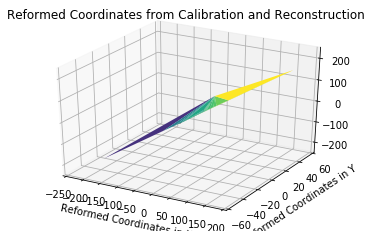

<Figure size 432x288 with 0 Axes>

In [185]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
plt.xlabel('Reformed Coordinates in X')
plt.ylabel('Reformed Coordinates in Y')
#plt.zlabel('Reformed Coordinates in Z')
#plt.autoscale(enable=True)
ax.set_ylim(-60,60)
ax.set_xlim(-250,200)
ax.set_zlim(-240,240)
plt.title('Reformed Coordinates from Calibration and Reconstruction')
plt.savefig('Reconstruction_heatmap.png')
plt.show()
 
# to Add a color bar which maps values to colors.
#surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
#fig.colorbar( surf, shrink=0.5, aspect=5)
plt.savefig('Reconstruction_heatmap.png')
plt.show()


In [171]:
df.to_hdf('Reconstruction_coordinates_handle.h5', key='df', mode='w')